To launch in SuperCloud from a Computed Node

LLsub -i full #for an exclusive node

LLsub -i -s 40 #for node with 40 CPUs

LLsub -i -s 40 -g volta:1 #for node with 40 CPUs and 1 Volta GPU

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-gpu --gres=gpu:volta:1 --cpus-per-task=40 srun    --pty bash -i

salloc  --job-name=interactive --qos=high --time=02:00:00 --partition=debug-cpu --cpus-per-task=40 srun  --pty bash -i

LLsub -i full

module load anaconda/2023a-pytorch

jupyter lab --no-browser --ip=0.0.0.0 --port=8890

In [ ]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dgd.utils.utils5 import *
from dgd.utils.nnassignments import *
from dgd.utils.verification import *
import pickle
import pandas as pd
import json
import networkx as nx
from tqdm.notebook import tqdm
import time
import subprocess
import multiprocessing
import random
from collections import defaultdict
import socket
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from itertools import cycle
from pathlib import Path
import time
from sklearn.metrics import mean_squared_error, r2_score
import csv
import math
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D         

In [ ]:
#Set seed
global_seed = int.from_bytes(os.urandom(4), "little")
print(f"Generated random seed {global_seed}")
random.seed(global_seed)            
np.random.seed(global_seed)
th.manual_seed(global_seed)    

In [ ]:
hostname = socket.gethostname()
print(f"Node: {hostname}")
num_gpus = th.cuda.device_count()
print(f"GPUs: {num_gpus}")
for idx in range(num_gpus):
    props = th.cuda.get_device_properties(idx)
    print(f"GPU {idx}: {props.name} "
          f"({props.total_memory // 1024**2} MB, "
          f"compute capability {props.major}.{props.minor})")
print(f"CPUs in compute node: {multiprocessing.cpu_count()}")

CPUs_alloc = len(os.sched_getaffinity(0)) if hasattr(os, "sched_getaffinity") else int(os.environ.get("SLURM_CPUS_PER_TASK", os.cpu_count() or 1))
print(f"CPUs allocated: {CPUs_alloc}")

#### Parameters

In [ ]:
'''
circuit_name = "0x17"

#File with designs 
file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250610_run1_0x17_sampling_bias/optimal_topologies/gate_assignments_using_neural_networks"

Path(output_dir).mkdir(parents=True, exist_ok=True)
'''

In [ ]:

circuit_name = "0x6D"

#File with designs 
file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_0x6D/seed_1/optimal_topologies/optimal_topologies.pkl"

# Set up output directory
output_dir = f"/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_0x6D/seed_1/optimal_topologies/gate_assignments_using_neural_networks"

Path(output_dir).mkdir(parents=True, exist_ok=True)




In [ ]:
with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

In [ ]:
type(reduced_graphs)

In [ ]:
#Plot biological circuit designs
for idx, biological_circuit in enumerate(reduced_graphs):
    print(f"Circuit design {idx}")
    #small_topology_plot(biological_circuit)
    plot_circuit_layered(biological_circuit, show_in_notebook=True, notebook_width = 500, save = False) 

In [ ]:
#Select graph in graphs
#selected_graph = 2  #for 0x17

selected_graph = 0  #for 0x6D

#It will compute valid permutations if True, otherwise it will try to load a prior computation    
compute_valid_permutations = False

# Total valid permutations to process for trainning data
percentage = 0.05    

batch_size = 1000              # Size of each processing batch
solutions_per_file = 250000    # Number of solutions to save per file

In [ ]:
num_epochs_circuit_score_model = 25

num_epochs_toxicity_score_model = 25


In [ ]:
topology_networkx = reduced_graphs[selected_graph] 

In [ ]:
topology_networkx = reduced_graphs[selected_graph] 

# Define the input nodes
input_nodes = [node for node in topology_networkx.nodes() if topology_networkx.in_degree(node) == 0]
# Generate all permutations of the input nodes
permutations = list(itertools.permutations(input_nodes))
# Create a list to store the permuted graphs
permuted_graphs = []

for perm in permutations:
    new_graph = permute_graph(topology_networkx, perm, input_nodes)

    if calculate_truth_table_v2(new_graph) == calculate_truth_table_v2(topology_networkx):
        idx = len(permuted_graphs)          
        print(f"Permuted graphs {idx}: {perm}")      
        permuted_graphs.append(new_graph)  
        

In [ ]:
print(f"Base circuit design")
topology_plot_with_attrs(topology_networkx, seed = 1459)

for idx, topology_permutation in enumerate(permuted_graphs):
    print(f"Permutation {idx}")
    #small_topology_plot(topology_permutation) 
    plot_circuit_layered(topology_permutation, show_in_notebook=True, notebook_width = 500, save = False) 
    result = validate_dag(topology_permutation, 1, raise_on_error=True, plot_on_error=True)
    print(result)


In [ ]:
#permutation_index = 2 #for 0x17
permutation_index = 0 #for 0x6D

In [ ]:
for nodes in topology_networkx.nodes(data = True):
    print(nodes)

## Import experimental data

In [ ]:
input_signals_list_small_molecules, input_names, _ , _ = load_input_data("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/input_data_3_inputs_POSTECH.json")
for row in input_signals_list_small_molecules:
    print(row)

In [ ]:
input_signals_list_binary = binary_truth_table(len(input_signals_list_small_molecules[0]))
for row in input_signals_list_binary:
    print(row)

In [ ]:
'''
input_signals_list_small_molecules = [
    {0: 0.0278, 1: 0.0022, 2: 0.0042},  # First set of input signals
    {0: 0.0278, 1: 0.0022, 2: 2.0082},  # Second set of input signals
    {0: 0.0278, 1: 5.0543, 2: 0.0042},  # Third set of input signals
    {0: 0.0278, 1: 5.0543, 2: 2.0082},  # First set of input signals
    {0: 3.9239, 1: 0.0022, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 0.0022, 2: 2.0082},  # Third set of input signals    
    {0: 3.9239, 1: 5.0543, 2: 0.0042},  # Second set of input signals
    {0: 3.9239, 1: 5.0543, 2: 2.0082},  # Third set of input signals  
]    

input_signals_list_binary = [
    {0: 0, 1: 0, 2: 0},  # First set of input signals
    {0: 0, 1: 0, 2: 1},  # Second set of input signals
    {0: 0, 1: 1, 2: 0},  # Third set of input signals
    {0: 0, 1: 1, 2: 1},  # First set of input signals
    {0: 1, 1: 0, 2: 0},  # Second set of input signals
    {0: 1, 1: 0, 2: 1},  # Third set of input signals    
    {0: 1, 1: 1, 2: 0},  # Second set of input signals
    {0: 1, 1: 1, 2: 1},  # Third set of input signals  
]   
'''

# Load the part response experimental data
with open("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/response_data_POSTECH.json") as f:
    repressor_data = json.load(f)

# Create DataFrame
postech_v1_hill_function_parameters = pd.DataFrame(repressor_data)

postech_v1_hill_function_parameters

protein_groups = [
    {3, 4, 5},
    {10, 11, 12},
    {14, 15},
    {16, 17, 18, 19},
]

# Load cell growth experimental data
file_path = '/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/growth_data_POSTECH.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract all gate toxicity data
gate_toxicity_data = [item for item in data if item.get("collection") == "gate_toxicity"]

# Convert the list of dictionaries into a DataFrame
gate_toxicity_df = pd.DataFrame(gate_toxicity_data)

# show up to 10 decimal places; adjust as you like
pd.set_option("display.float_format", "{:.10f}".format)

postech_v1_hill_function_parameters


In [ ]:
gate_toxicity_df

### Adquire data from objective objective function 

#### Load possible permutations without repeating repressor

In [ ]:
gate_count, info = energy_score(topology_networkx, check_implicit_OR_existence_v3)
print(f"Gate count: {gate_count}")
print(f"Info: {info}")

In [ ]:
DATA_DIR = Path("/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data")  
                 
file_path = DATA_DIR / "gate_permutations" / f"valid_permutations_{gate_count}_gates.h5"

list_of_gates_indices = list(range(len(postech_v1_hill_function_parameters)))
if compute_valid_permutations:
    print("Computing valid gate permutations")
    valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
    save_valid_permutations(valid_permutations, file_path)
else:
    if file_path.is_file():           
        print(f"Found: {file_path}")
        print("Loading valid gate permutations")
        valid_permutations = load_valid_permutations(file_path)
        
    else:
        print(f"Missing: {file_path}")
        print("Computing valid gate permutations because file does not exist")   
        valid_permutations = generate_and_filter_permutations_v2(list_of_gates_indices, gate_count, protein_groups, max_per_group=1)
        save_valid_permutations(valid_permutations, file_path)   
        
print(f"Total valid permutations: {len(valid_permutations)}")
print("Example permutation:", valid_permutations[0] if valid_permutations else "No permutations found")

#### Set sample size

In [ ]:
num_samples = round(len(valid_permutations)*percentage) 
subsample_size = num_samples

#### Adquire trainning data (multiple cores)

In [ ]:
Gi = permuted_graphs[permutation_index]
list(Gi.nodes(data = True))

In [ ]:
topology_plot_with_attrs(Gi)

In [ ]:
nodelist = sorted(Gi.nodes())
list(sorted(Gi.nodes(data = True)))

In [ ]:
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()
adj_matrix

In [ ]:
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Remove disconnected nodes (nodes with neither incoming nor outgoing edges)
disconnected_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
G.remove_nodes_from(disconnected_nodes)
topology_plot_with_attrs(G)

In [ ]:
input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
output_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

# Filter nodes that are neither inputs nor outputs
non_io_nodes = [node for node in G.nodes() if node not in input_nodes and node not in output_nodes]
non_io_nodes

In [ ]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

In [ ]:
# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=valid_permutations,
    experimental_params=postech_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/training_data_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
    num_samples=num_samples,           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file,     # Save every solutions_per_file solutions
    num_cores = CPUs_alloc
    )

In [ ]:
run_timing_analysis = False

Timing plot with total times

In [ ]:
if run_timing_analysis:
    import time, random
    from pathlib import Path
    import matplotlib.pyplot as plt

    core_grid = [10, 20, 40, 80, 100, 120]  

    # Fix the workload so runs are comparable
    rng = random.Random(123)
    random_indices = rng.sample(range(len(valid_permutations)), num_samples)
    fixed_perms = [valid_permutations[i] for i in random_indices]

    times = []
    for n in core_grid:
        print(f"\n=== Testing num_cores={n} ===")
        t0 = time.perf_counter()
        
        # Use a unique subdir so runs don't interfere
        outdir_n = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/mp_time_data_v1/{circuit_name}_design_{selected_graph}_permutation_{permutation_index}_{n}_workers"

        results_summary = parallel_process_circuits(
            adj_matrix=adj_matrix,
            valid_permutations=fixed_perms,                   # <- fixed workload
            experimental_params=postech_v1_hill_function_parameters,
            input_signals_small=input_signals_list_small_molecules,
            input_signals_binary=input_signals_list_binary,
            gate_toxicity_df=gate_toxicity_df,
            output_dir=outdir_n,                              # <- unique output
            num_samples=num_samples,
            batch_size=batch_size,
            solutions_per_file=solutions_per_file,
            num_cores=n
        )
        times.append(time.perf_counter() - t0)

    # Plot
    plt.figure()
    plt.plot(core_grid, times, "-o")
    plt.xlabel("num_cores (processes)")
    plt.ylabel("Runtime (s)")
    plt.title("Runtime vs num_cores")
    plt.grid(True)
    plt.show()

Timing plot with time versus solutions

In [ ]:
if run_timing_analysis:
    import time, random
    from pathlib import Path
    import matplotlib.pyplot as plt

    core_grid = [20, 40, 80]  # ≤ CPUs_alloc

    # Fix workload for fair comparison
    rng = random.Random(123)
    random_indices = rng.sample(range(len(valid_permutations)), num_samples)
    fixed_perms = [valid_permutations[i] for i in random_indices]

    run_summaries = []

    for n in core_grid:
        print(f"\n=== Testing num_cores={n} ===")
        outdir_n = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/mp_time_data_v2/{circuit_name}_design_{selected_graph}_permutation_{permutation_index}_{n}_workers"

        summary = parallel_process_circuits(
            adj_matrix=adj_matrix,
            valid_permutations=fixed_perms,                   # fixed workload
            experimental_params=postech_v1_hill_function_parameters,
            input_signals_small=input_signals_list_small_molecules,
            input_signals_binary=input_signals_list_binary,
            gate_toxicity_df=gate_toxicity_df,
            output_dir=outdir_n,                              # unique output
            num_samples=num_samples,
            batch_size=batch_size,
            solutions_per_file=solutions_per_file,
            num_cores=n
        )
        run_summaries.append((n, summary))

    # Plot: x = time, y = number of solutions 
    plt.figure()
    for n, summary in run_summaries:
        prog = summary['progress']  # list of (elapsed_s, processed_solutions)
        xs = [t/60.0 for (t, _) in prog]   # minutes on x-axis 
        ys = [s for (_, s) in prog]
        plt.plot(xs, ys, "-o", label=f"{n} cores")

        # mark final point
        plt.scatter(xs[-1], ys[-1])

    plt.xlabel("Time (minutes)")  
    plt.ylabel("Number of solutions processed")
    plt.title("Solutions vs Time for different num_cores")
    plt.grid(True)
    plt.legend(title="Workers")
    plt.tight_layout()
    plt.show()

### Load training data

In [ ]:
# Load all results
(permutations, toxicity_scores, circuit_scores, roadblocking_flags) = load_circuit_results(Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/training_data_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations.shape}")
    print(f"Toxicity scores shape: {toxicity_scores.shape}")
    print(f"Circuit scores shape: {circuit_scores.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags.shape}")

### List top biological designs in the training data

In [32]:
no_roadblock_mask_training_data = ~roadblocking_flags
permutations_no_roadblocking_training_data = permutations[no_roadblock_mask_training_data]
circuit_scores_no_roadblocking_training_data = circuit_scores[no_roadblock_mask_training_data]
toxicity_scores_no_roadblocking_training_data = toxicity_scores[no_roadblock_mask_training_data]
roadblocking_flags_no_roadblocking_training_data = roadblocking_flags[no_roadblock_mask_training_data]

toxicity_filter_training_data = toxicity_scores_no_roadblocking_training_data >= 0.75
permutations_no_roadblocking_toxicity_filtered_training_data = permutations_no_roadblocking_training_data[toxicity_filter_training_data]
circuit_scores_no_roadblocking_toxicity_filtered_training_data = circuit_scores_no_roadblocking_training_data[toxicity_filter_training_data]
toxicity_scores_no_roadblocking_toxicity_filtered_training_data = toxicity_scores_no_roadblocking_training_data[toxicity_filter_training_data]
roadblocking_flags_no_roadblocking_toxicity_filtered_training_data = roadblocking_flags_no_roadblocking_training_data[toxicity_filter_training_data]

#print(circuit_scores_no_roadblocking_toxicity_filtered_training_data)

In [33]:
print(len(circuit_scores_no_roadblocking_toxicity_filtered_training_data))

16


In [34]:
# Find top N circuit scores
N_training_data = 10  # Change this number to get more or fewer top scores
top_n_indices_training_data = np.argsort(circuit_scores_no_roadblocking_toxicity_filtered_training_data)[-N_training_data:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N_training_data} Circuit Scores (no roadblocking, toxicity >= 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details_training_data = {}

for rank, idx in enumerate(top_n_indices_training_data, 1):
    
    corresponding_index_training_data = idx

    best_permutation_training_data = permutations_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    roadblock_flag_training_data = roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[corresponding_index_training_data]

    print(f"{rank:4d} | {circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx]:12.4f} | "
          f"{toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx]:13.4f} | "
          f"{str(roadblock_flag_training_data):11} | {best_permutation_training_data}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details_training_data = {
            'circuit_score': circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'toxicity_score': toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
            'roadblocking': roadblock_flag_training_data,
            'permutation': best_permutation_training_data
        }

# Print detailed information for highest scoring design after the table
print("\n" + "-"*100)
print("Detailed information for highest scoring design:")
print("-"*100)
print(f"Highest actual circuit score: {highest_score_details_training_data['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details_training_data['toxicity_score']}")
print(f"Roadblocking: {highest_score_details_training_data['roadblocking']}")
print(f"Permutation: {highest_score_details_training_data['permutation']}")


Top 10 Circuit Scores (no roadblocking, toxicity >= 0.75):
Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation
----------------------------------------------------------------------------------------------------
   1 |       0.7620 |        0.7555 | False       | [ 0  2 13  4  1 15 10]
   2 |       0.6604 |        0.7505 | False       | [ 2 10  8 19  0  1 15]
   3 |       0.6144 |        0.7758 | False       | [ 9 10  7  4  0  2 15]
   4 |       0.6138 |        0.7641 | False       | [ 1 10  7  5  0  2 15]
   5 |       0.6135 |        0.7516 | False       | [ 9 10  7  5  0  2 15]
   6 |       0.5538 |        0.7523 | False       | [13  2  8 10  1 15  4]
   7 |       0.4059 |        0.7707 | False       | [13  2  8 15  1 10 19]
   8 |       0.2864 |        0.7501 | False       | [ 1 10  2  4  0 13 15]
   9 |       0.2674 |        0.7561 | False       | [ 1 10  8  5  2 13 15]
  10 |       0.2216 |        0.7864 | False       | [13 10  8  5  2  1 15]

---------------------

In [35]:
rows = []
for rank, idx in enumerate(top_n_indices_training_data, 1):
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_no_roadblocking_toxicity_filtered_training_data[idx],
        "Toxicity Score"  : toxicity_scores_no_roadblocking_toxicity_filtered_training_data[idx],
        "Roadblocking"    : roadblocking_flags_no_roadblocking_toxicity_filtered_training_data[idx],
        "Permutation"     : permutations_no_roadblocking_toxicity_filtered_training_data[idx],
    })


csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_top_designs_in_trainning_data_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n Saved {len(rows)} rows to {csv_path}")


 Saved 10 rows to /home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/Fig2_single_circuits_0x6D/seed_1/optimal_topologies/gate_assignments_using_neural_networks/0x6D_design_0_permutation_0/scores_top_designs_in_trainning_data_0x6D_0_0.csv


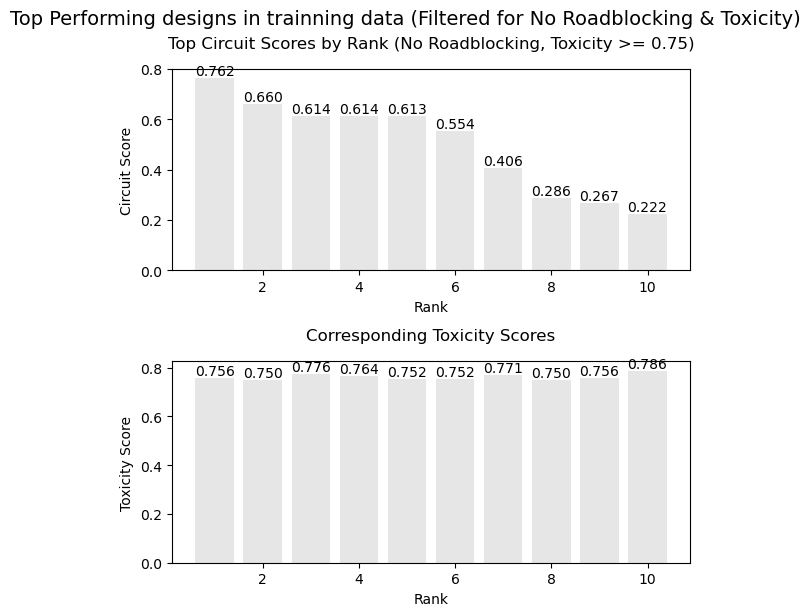


Statistics Summary:
--------------------------------------------------
Circuit Scores - Mean: 0.500, Std: 0.180
Toxicity Scores - Mean: 0.761, Std: 0.012


In [36]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N_training_data + 1))
circuit_scores_training_data_top = circuit_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]
toxicity_scores_training_data_top = toxicity_scores_no_roadblocking_toxicity_filtered_training_data[top_n_indices_training_data]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores_training_data_top, color='gainsboro', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank (No Roadblocking, Toxicity >= 0.75)', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
#ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores_training_data_top, color='gainsboro', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
#ax2.grid(False, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Top Performing designs in trainning data (Filtered for No Roadblocking & Toxicity)', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis_filtered.png', dpi=300, bbox_inches='tight')

plt.show()

# Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores_training_data_top):.3f}, Std: {np.std(circuit_scores_training_data_top):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores_training_data_top):.3f}, Std: {np.std(toxicity_scores_training_data_top):.3f}")

## Define model

In [37]:
'''
# Model Definition
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNN, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        return self.model(x)
'''

'\n# Model Definition\nclass RegressionNN(nn.Module):\n    def __init__(self, input_size, hidden_size, output_size):\n        super(RegressionNN, self).__init__()\n        self.flatten = nn.Flatten()\n        self.model = nn.Sequential(\n            nn.Linear(input_size, hidden_size),\n            nn.ReLU(),\n            nn.Linear(hidden_size, hidden_size),\n            nn.ReLU(),\n            nn.Linear(hidden_size, hidden_size),\n            nn.ReLU(),\n            nn.Linear(hidden_size, hidden_size),\n            nn.ReLU(),\n            nn.Linear(hidden_size, hidden_size),\n            nn.ReLU(),\n            nn.Linear(hidden_size, hidden_size),\n            nn.ReLU(),\n            nn.Linear(hidden_size, hidden_size),\n            nn.ReLU(),\n            nn.Linear(hidden_size, hidden_size),\n            nn.ReLU(),\n            nn.Linear(hidden_size, output_size)\n        )\n        \n    def forward(self, x):\n        x = self.flatten(x)\n        return self.model(x)\n'

In [38]:
import torch.nn as nn

class RegressionNN(nn.Module):
    """
    Fully-connected MLP with configurable depth and width.
    num_layers = number of HIDDEN layers (not counting the output layer).
    """
    def __init__(self, input_size, hidden_size, output_size=1,
                 num_layers=5, dropout=0.1, activation=nn.ReLU):
        super().__init__()
        assert num_layers >= 1, "num_layers must be >= 1"

        layers = []
        act = activation  # pass a class like nn.ReLU or nn.GELU

        # First hidden layer: input -> hidden
        layers += [nn.Linear(input_size, hidden_size), act()]
        if dropout and dropout > 0:
            layers += [nn.Dropout(dropout)]

        # Remaining hidden layers: hidden -> hidden
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), act()]
            if dropout and dropout > 0:
                layers += [nn.Dropout(dropout)]

        # Output layer: hidden -> output
        layers += [nn.Linear(hidden_size, output_size)]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # X is one-hot with shape [B, num_parts, num_classes]
        # flatten to [B, num_parts * num_classes]
        x = x.flatten(1)
        return self.model(x)

### Prepare data for training 

In [39]:
X_all = np.array(permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
y_all = np.column_stack((toxicity_scores, circuit_scores)).astype(np.float32)  # Convert to a NumPy array
roadblocking_flags = np.array(roadblocking_flags)  # Convert all_roadblocking_flags to a NumPy array

num_classes = len(postech_v1_hill_function_parameters)
num_biological_parts = gate_count

In [40]:
# Data Preparation and Filter by circuit score > 0and roadblocking
#filter_mask = (y_all[:, 1] > 0) & (roadblocking_flags == False)

# Data Preparation and Filter by circuit score > n
filter_mask = y_all[:, 1] >= 0

X_all_filtered = X_all[filter_mask]
y_all_circuit_scores_filtered = y_all[filter_mask, 1]
y_all_toxicity_scores_filtered = y_all[filter_mask, 0]

print("Data " ,len(X_all_filtered))

#Subsample randomly and maintain order of data

# Check if we have enough samples and generate indices for subsampling
if len(X_all_filtered) >= subsample_size:
    # Get random indices and sort them to maintain order
    subsample_indices = np.sort(np.random.choice(len(X_all_filtered), subsample_size, replace=False))
else:
    print(f"Warning: Requested {subsample_size} samples, but only {len(X_all_filtered)} are available after filtering.")
    subsample_indices = np.arange(len(X_all_filtered))  # Simply use all indices in order
    subsample_size = len(X_all_filtered)  # Adjust subsample_size to the available data
    
# Subsample the data
X_all_filtered_subsampled = X_all_filtered[subsample_indices]
y_all_circuit_scores_filtered_subsampled = y_all_circuit_scores_filtered[subsample_indices]
y_all_toxicity_scores_filtered_subsampled = y_all_toxicity_scores_filtered[subsample_indices]

# Convert X to PyTorch tensor and perform one-hot encoding
X_all_filtered_subsampled_tensor = th.from_numpy(X_all_filtered_subsampled).long()
X_all_filtered_subsampled_tensor_one_hot = F.one_hot(X_all_filtered_subsampled_tensor, num_classes=num_classes).float()

# Convert y to PyTorch tensors
y_all_circuit_scores_filtered_subsampled_tensor = th.from_numpy(y_all_circuit_scores_filtered_subsampled).float().unsqueeze(1)
y_all_toxicity_scores_filtered_subsampled_tensor = th.from_numpy(y_all_toxicity_scores_filtered_subsampled).float().unsqueeze(1)

# Split the data into train / val / test
train_ratio = 0.80
val_ratio   = 0.10  # test will be the remainder 

num_samples = X_all_filtered_subsampled_tensor_one_hot.shape[0]
num_train = int(train_ratio * num_samples)
num_val   = int(val_ratio * num_samples)
num_test  = num_samples - num_train - num_val  # ensure all samples are used

perm = np.random.permutation(num_samples)
train_idx = perm[:num_train]
val_idx   = perm[num_train:num_train + num_val]
test_idx  = perm[num_train + num_val:]

# Build splits
X_training_set = X_all_filtered_subsampled_tensor_one_hot[train_idx]
y_circuit_scores_training_set = y_all_circuit_scores_filtered_subsampled_tensor[train_idx]
y_toxicity_scores_training_set = y_all_toxicity_scores_filtered_subsampled_tensor[train_idx]

X_val_set = X_all_filtered_subsampled_tensor_one_hot[val_idx]
y_circuit_scores_val_set = y_all_circuit_scores_filtered_subsampled_tensor[val_idx]
y_toxicity_scores_val_set = y_all_toxicity_scores_filtered_subsampled_tensor[val_idx]

X_test_set = X_all_filtered_subsampled_tensor_one_hot[test_idx]
y_circuit_scores_test_set = y_all_circuit_scores_filtered_subsampled_tensor[test_idx]
y_toxicity_scores_test_set = y_all_toxicity_scores_filtered_subsampled_tensor[test_idx]

print(f"Split sizes -> train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

# Device Setup
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Shuffle training data
shuffle_indices = th.randperm(X_training_set.size(0))
X_training_set_shuffled = X_training_set[shuffle_indices].to(device)
y_circuit_scores_training_set_shuffled = y_circuit_scores_training_set[shuffle_indices].to(device)
y_toxicity_scores_training_set_shuffled = y_toxicity_scores_training_set[shuffle_indices].to(device)

# Move val/test to device
X_val_set = X_val_set.to(device)
y_circuit_scores_val_set = y_circuit_scores_val_set.to(device)
y_toxicity_scores_val_set = y_toxicity_scores_val_set.to(device)

X_test_set = X_test_set.to(device)
y_circuit_scores_test_set = y_circuit_scores_test_set.to(device)
y_toxicity_scores_test_set = y_toxicity_scores_test_set.to(device)


Data  3649968
Split sizes -> train: 2919974, val: 364996, test: 364998
Using device: cuda


### Trainning

In [41]:
num_epochs_circuit_score_model = 25

In [42]:
# Model Initialization
input_size = num_biological_parts * num_classes
hidden_size = 100
output_size = 1

criterion = nn.MSELoss()
model_circuit_score = RegressionNN(input_size, hidden_size, output_size, num_layers=7, dropout=0, activation=nn.ReLU).to(device)
optimizer_circuit_score = optim.Adam(model_circuit_score.parameters(), lr=0.001)

In [43]:
'''
circuit_score_model_sampler = weighted_circuit_score_sampler(y_circuit_scores_training_set_shuffled, seed=global_seed)

model_circuit_score_losses = train_model_minibatch_early_stoping(
    model_circuit_score,
    X_training_set_shuffled, y_circuit_scores_training_set_shuffled,
    X_val_set, y_circuit_scores_val_set,
    optimizer_circuit_score, criterion,
    num_epochs=num_epochs_circuit_score_model,
    batch_size=4096,
    shuffle=True,                 
    sampler=None,
    seed=global_seed,
    grad_clip=None,
    evaluate_validation_set=True,
    early_stop_patience=5,           
    early_stop_min_delta=0.001,
    restore_best_on_stop=False
)
'''


'\ncircuit_score_model_sampler = weighted_circuit_score_sampler(y_circuit_scores_training_set_shuffled, seed=global_seed)\n\nmodel_circuit_score_losses = train_model_minibatch_early_stoping(\n    model_circuit_score,\n    X_training_set_shuffled, y_circuit_scores_training_set_shuffled,\n    X_val_set, y_circuit_scores_val_set,\n    optimizer_circuit_score, criterion,\n    num_epochs=num_epochs_circuit_score_model,\n    batch_size=4096,\n    shuffle=True,                 \n    sampler=None,\n    seed=global_seed,\n    grad_clip=None,\n    evaluate_validation_set=True,\n    early_stop_patience=5,           \n    early_stop_min_delta=0.001,\n    restore_best_on_stop=False\n)\n'

In [45]:
model_circuit_score_losses = train_model_minibatch_early_stoping(
    model_circuit_score,
    X_training_set_shuffled, y_circuit_scores_training_set_shuffled,
    X_val_set, y_circuit_scores_val_set,
    optimizer_circuit_score, criterion,
    num_epochs=num_epochs_circuit_score_model,
    batch_size=4096,
    shuffle=True,                 
    sampler=None,
    seed=global_seed,
    grad_clip=None,
    evaluate_validation_set=False,
    early_stop_patience=5,           
    early_stop_min_delta=0.001,
    restore_best_on_stop=False
)


Training Progress:   0%|                                                                                                                                                                                   | 0/25 [00:02<?, ?it/s]


KeyboardInterrupt: 

Save losses

In [ ]:
save_dir = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
save_dir.mkdir(parents=True, exist_ok=True)   

save_path = save_dir / f"model_circuit_score_losses_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}.pt"
th.save({"train": model_circuit_score_losses[0], "eval": model_circuit_score_losses[1]}, save_path)
print("saved to:", save_path)

Load losses

In [ ]:
save_dir = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
save_path = save_dir / f"model_circuit_score_losses_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}.pt"

# load
d = th.load(save_path, map_location="cpu")
train_losses = d["train"]
eval_losses  = d["eval"]
model_circuit_score_losses = (train_losses, eval_losses)

print("loaded:",
      f"train {len(train_losses)} points",
      f"eval {len(eval_losses)} points")

In [ ]:
num_epochs_toxicity_score_model = 25

In [ ]:
# Model Initialization
input_size = num_biological_parts * num_classes
hidden_size = 100
output_size = 1

criterion = nn.MSELoss()

model_toxicity_score = RegressionNN(input_size, hidden_size, output_size, num_layers=5, dropout=0, activation=nn.ReLU).to(device)
optimizer_toxicity_score = optim.Adam(model_toxicity_score.parameters(), lr=0.001)

In [ ]:
model_toxicity_score_losses = train_model_minibatch_early_stoping(
    model_toxicity_score,
    X_training_set_shuffled, y_toxicity_scores_training_set_shuffled,
    X_val_set, y_toxicity_scores_val_set,
    optimizer_toxicity_score, criterion,
    num_epochs=num_epochs_toxicity_score_model,
    batch_size=4096,
    shuffle=True,                 
    sampler=None,
    seed=global_seed,
    grad_clip=None,
    evaluate_validation_set=False,
    early_stop_patience=5,           
    early_stop_min_delta=0.00001,
    restore_best_on_stop=False
)

In [ ]:
save_dir = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
save_dir.mkdir(parents=True, exist_ok=True)   # create the folder if missing

save_path = save_dir / "model_toxicity_score_losses_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}.pt"
th.save({"train": model_toxicity_score_losses[0], "eval": model_toxicity_score_losses[1]}, save_path)
print("saved to:", save_path)

In [ ]:
save_dir  = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}"
save_path = save_dir / f"model_toxicity_score_losses_{circuit_name}_design_{selected_graph}_permutation_{permutation_index}.pt"

# load
d = th.load(save_path, map_location="cpu")
tox_train_losses = d["train"]
tox_eval_losses  = d["eval"]
model_toxicity_score_losses = (tox_train_losses, tox_eval_losses)

print("loaded:",
      f"train {len(tox_train_losses)} points,",
      f"eval {len(tox_eval_losses)} points")

Plot losses

In [ ]:
# Figure-wide typography and sizing (unchanged)
plt.rcParams.update({
    "font.size": 6,
    "axes.titlesize": 6,
    "axes.labelsize": 6,
    "legend.fontsize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
})

# Canvas set-up (unchanged)
pt_to_in = lambda pt: pt / 72.0
edge_col, edge_w = "#58595B", 0.5

fig, (ax_circ, ax_tox) = plt.subplots(
    1, 2,
    figsize=(pt_to_in(210), pt_to_in(100)),
    dpi=250,
    sharex=False, sharey=False
)
fig.subplots_adjust(wspace=0.30)

# --- Helper for safe plotting with optional validation ---
def _has_data(arr):
    try:
        return (arr is not None) and (np.size(arr) > 0)
    except Exception:
        return False

def _plot_losses(ax, train_losses, val_losses, num_epochs, title):
    # Training curve
    if _has_data(train_losses):
        n_train = min(num_epochs, len(train_losses))
        ax.plot(np.arange(n_train), train_losses[:n_train],
                label="Training", linewidth=0.8, color="#417FF1")

    # Validation curve (only if provided)
    if _has_data(val_losses):
        n_val = min(num_epochs, len(val_losses))
        ax.plot(np.arange(n_val), val_losses[:n_val],
                label="Validation", linewidth=0.8, color="#E06C4B")

    ax.set_xlabel("Epochs", labelpad=4)
    ax.set_ylabel("Mean squared error", labelpad=4)
    ax.set_title(title)

    # Only show legend if at least one line exists
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(loc="upper right")

# Loss curves (now robust to missing/None validation losses)
_plot_losses(
    ax_circ,
    model_circuit_score_losses[0],
    (model_circuit_score_losses[1]
     if isinstance(model_circuit_score_losses, (list, tuple, np.ndarray)) and len(model_circuit_score_losses) > 1
     else None),
    num_epochs_circuit_score_model,
    "Circuit score loss"
)

_plot_losses(
    ax_tox,
    model_toxicity_score_losses[0],
    (model_toxicity_score_losses[1]
     if isinstance(model_toxicity_score_losses, (list, tuple, np.ndarray)) and len(model_toxicity_score_losses) > 1
     else None),
    num_epochs_toxicity_score_model,
    "Toxicity score loss"
)

# Shared axis cosmetics
for ax in (ax_circ, ax_tox):
    # frame colour / width
    for spine in ax.spines.values():
        spine.set_color(edge_col)
        spine.set_linewidth(edge_w)

    # tick appearance
    ax.tick_params(direction="out", length=4, width=edge_w,
                   colors=edge_col, pad=1)

    # tidy y-ticks
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

    # label colour
    ax.xaxis.label.set_color(edge_col)
    ax.yaxis.label.set_color(edge_col)

    # optional grid
    # ax.grid(False, linestyle="--", linewidth=0.3, alpha=0.7)
    
    ax.set_yscale('log')

# Different major-tick spacing for each panel
ax_circ.xaxis.set_major_locator(mticker.MultipleLocator(5))  # left panel
ax_tox.xaxis.set_major_locator(mticker.MultipleLocator(5))   # right panel

plt.tight_layout()
plt.show()


In [ ]:
fig.savefig(Path(output_dir)  / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/loss_curves_{circuit_name}_{selected_graph}_{permutation_index}.pdf",  # or .png / .svg, etc.
            dpi=250,                         # keep same resolution as on-screen
            bbox_inches="tight")  

### Characterization on test set

In [ ]:
# Get model predictions on test set
model_circuit_score.eval()
model_toxicity_score.eval()

# Move test data and models to available device
model_circuit_score = model_circuit_score.to(device)
model_toxicity_score = model_toxicity_score.to(device)
X_test_set = X_test_set.to(device)

# Make predictions
with th.no_grad():
    test_pred_circuit = model_circuit_score(X_test_set)
    test_pred_toxicity = model_toxicity_score(X_test_set)

# Convert everything to numpy arrays for plotting
test_pred_circuit = test_pred_circuit.cpu().numpy().flatten()
test_pred_toxicity = test_pred_toxicity.cpu().numpy().flatten()
test_actual_circuit = y_circuit_scores_test_set.cpu().numpy().flatten()
test_actual_toxicity = y_toxicity_scores_test_set.cpu().numpy().flatten()


plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

edge_col, edge_w = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72           

fig, (ax_circ, ax_tox) = plt.subplots(
    1, 2,
    figsize=(pt_to_in(210), pt_to_in(100)),  
    dpi=250,
    sharex=False, sharey=False
)
fig.subplots_adjust(wspace=0.30)

ax_circ.scatter(test_actual_circuit, test_pred_circuit,
                s=4,  c="#417FF1", alpha=1, edgecolors="none", rasterized=False)
ax_circ.plot([test_actual_circuit.min(), test_actual_circuit.max()],
             [test_actual_circuit.min(), test_actual_circuit.max()],
             linestyle="--", linewidth=0.5, color="#E06C4B", label="Perfect prediction")
ax_circ.set_xlabel("Actual circuit score",  labelpad=4)
ax_circ.set_ylabel("Predicted circuit score", labelpad=4)
ax_circ.set_title("Circuit: predicted vs actual")
ax_circ.legend(loc="upper left", markerscale=5)

ax_tox.scatter(test_actual_toxicity, test_pred_toxicity,
               s=4,  c="#417FF1", alpha=1, edgecolors="none", rasterized=False)
ax_tox.plot([test_actual_toxicity.min(), test_actual_toxicity.max()],
            [test_actual_toxicity.min(), test_actual_toxicity.max()],
            linestyle="--", linewidth=0.5, color="#E06C4B", label="Perfect prediction")
ax_tox.set_xlabel("Actual toxicity score",   labelpad=4)
ax_tox.set_ylabel("Predicted toxicity score", labelpad=4)
ax_tox.set_title("Toxicity: predicted vs actual")
ax_tox.legend(loc="upper left", markerscale=5)

for ax in (ax_circ, ax_tox):
    for spine in ax.spines.values():
        spine.set_color(edge_col); spine.set_linewidth(edge_w)

    ax.tick_params(direction="out", length=4, width=edge_w,
                   colors=edge_col, pad=1)
    ax.xaxis.label.set_color(edge_col)
    ax.yaxis.label.set_color(edge_col)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8))

plt.tight_layout()
plt.show()

test_circuit_corr     = np.corrcoef(test_actual_circuit,  test_pred_circuit)[0, 1]
test_toxicity_corr    = np.corrcoef(test_actual_toxicity, test_pred_toxicity)[0, 1]
test_circuit_mse      = mean_squared_error(test_actual_circuit,  test_pred_circuit)
test_toxicity_mse     = mean_squared_error(test_actual_toxicity, test_pred_toxicity)

print("\nTest-set circuit score:")
print(f"  MSE  = {test_circuit_mse:.4f}")
print(f"  RMSE = {np.sqrt(test_circuit_mse):.4f}")
print(f"  R²   = {r2_score(test_actual_circuit,  test_pred_circuit):.4f}")
print(f"  ρ    = {test_circuit_corr:.4f}")

print("\nTest-set toxicity score:")
print(f"  MSE  = {test_toxicity_mse:.4f}")
print(f"  RMSE = {np.sqrt(test_toxicity_mse):.4f}")
print(f"  R²   = {r2_score(test_actual_toxicity, test_pred_toxicity):.4f}")
print(f"  ρ    = {test_toxicity_corr:.4f}")


metrics_csv = Path(output_dir)/f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_performance_on_testing_set.csv"

df = pd.DataFrame([
    ["circuit",  len(test_actual_circuit),  test_circuit_mse,  np.sqrt(test_circuit_mse),
     r2_score(test_actual_circuit,  test_pred_circuit),  test_circuit_corr],
    ["toxicity", len(test_actual_toxicity), test_toxicity_mse, np.sqrt(test_toxicity_mse),
     r2_score(test_actual_toxicity, test_pred_toxicity), test_toxicity_corr],
], columns=["task", "n", "MSE", "RMSE", "R2", "PearsonR"])

df.to_csv(metrics_csv, index=False, mode="a", header=not os.path.exists(metrics_csv))
print(f"Saved metrics to {metrics_csv}")



In [ ]:
fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/predictions_on_test_set_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")


In [ ]:
stop

### After training, save the models

In [ ]:
# Save the circuit-score model
save_model(
    model_circuit_score,
    Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_circuit_score_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)


In [ ]:

# Save the toxicity-score model
save_model(
    model_toxicity_score,
    Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_toxicity_score_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)

###  Load trained model 

In [ ]:
# Initialize the models
input_size = num_biological_parts * num_classes # Must match the input size used during training
hidden_size = 100    # Must match the hidden size used during training
output_size = 1      # Must match the output size used during training

model_circuit_score = RegressionNN(input_size, hidden_size, output_size, num_layers=7, dropout=0, activation=nn.ReLU)
model_toxicity_score = RegressionNN(input_size, hidden_size, output_size, num_layers=5, dropout=0, activation=nn.ReLU)



# Save the circuit-score model
load_model(
    model_circuit_score,
    Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_circuit_score_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)

# Save the toxicity-score model
load_model(
    model_toxicity_score,
    Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/model_toxicity_score_{circuit_name}_{selected_graph}_{permutation_index}.pth"
)

## Predictions

In [ ]:
#X_valid_permutations = np.array(valid_permutations).astype(np.float32)
X_valid_permutations_tensor = th.as_tensor(valid_permutations, dtype=th.long)
device = th.device("cuda" if th.cuda.is_available() else "cpu")

model_circuit_score  = model_circuit_score.to(device).eval()
model_toxicity_score = model_toxicity_score.to(device).eval()


N = X_valid_permutations_tensor.shape[0]

B = 1000000  # batch size

c_out, t_out = [], []
print("Performing batched predictions")
start = time.time()
with th.inference_mode():
    for s in range(0, N, B):
        e = min(s + B, N)
        idx = X_valid_permutations_tensor[s:e].to(device, non_blocking=True)
        x_oh = F.one_hot(idx, num_classes=20).float()
        c_out.append(model_circuit_score(x_oh).detach().cpu())
        t_out.append(model_toxicity_score(x_oh).detach().cpu())
        del idx, x_oh  # release memory promptly

y_predicted_circuit_scores  = th.cat(c_out).numpy().flatten()
y_predicted_toxicity_scores = th.cat(t_out).numpy().flatten()

print("Done performing predictions. Time to make predictions:", time.time() - start)


Timing analysis 

In [ ]:
if run_timing_analysis:
    
    import time
    import math
    import numpy as np
    import matplotlib.pyplot as plt

    import torch as th
    import torch.nn.functional as F

    # --- Your existing setup (unchanged in spirit) ---
    # valid_permutations, model_circuit_score, model_toxicity_score must already exist.

    X_valid_permutations_tensor = th.as_tensor(valid_permutations, dtype=th.long)
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    model_circuit_score  = model_circuit_score.to(device).eval()
    model_toxicity_score = model_toxicity_score.to(device).eval()

    N = X_valid_permutations_tensor.shape[0]

    # --- Helper: run YOUR code once for a given B and return elapsed time ---
    def run_once_and_time(B, verbose=False):
        if verbose:
            print("Performing batched predictions")
        if device.type == "cuda":
            th.cuda.synchronize()

        start = time.perf_counter()

        c_out, t_out = [], []
        with th.inference_mode():
            for s in range(0, N, B):
                e = min(s + B, N)
                idx = X_valid_permutations_tensor[s:e].to(device, non_blocking=True)
                x_oh = F.one_hot(idx, num_classes=20).float()
                c_out.append(model_circuit_score(x_oh).detach().cpu())
                t_out.append(model_toxicity_score(x_oh).detach().cpu())
                del idx, x_oh  # release memory promptly

        # Finalize outputs exactly like your code
        y_predicted_circuit_scores  = th.cat(c_out).numpy().flatten()
        y_predicted_toxicity_scores = th.cat(t_out).numpy().flatten()

        if device.type == "cuda":
            th.cuda.synchronize()
        elapsed = time.perf_counter() - start

        if verbose:
            print("Done performing predictions. Time to make predictions:", elapsed)

        # Clean up big temporaries between runs
        del c_out, t_out, y_predicted_circuit_scores, y_predicted_toxicity_scores
        return elapsed

    # --- Choose batch sizes to test (powers of two + N and 1_000_000 if useful) ---
    #base_B = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1_000_000, N]
    base_B = [1000, 10000, 100000, 500000, 1_000_000, 10_000_000, N]
    B_values = sorted(set([b for b in base_B if b > 0]))

    # --- Measure ---
    times = []
    print(f"Measuring on {device} over N={N} examples...")
    for B in B_values:
        try:
            t = run_once_and_time(B, verbose=False)
        except RuntimeError as e:
            # Gracefully mark OOM/other errors
            if "out of memory" in str(e).lower():
                if device.type == "cuda":
                    th.cuda.empty_cache()
                t = float("nan")
            else:
                raise
        times.append(t)
        status = f"{t:.3f}s" if (t == t and t is not None) else "OOM/NaN"
        thr = (N / t) if (t and t == t) else float("nan")
        thr_str = f"{thr:,.0f}/s" if thr == thr else "—"
        print(f"B={B:>8}  time={status:>8}  throughput={thr_str}")

    # --- Plot time vs B ---
    valid = ~np.isnan(np.array(times))
    plt.figure(figsize=(7, 4.5))
    plt.plot(np.array(B_values)[valid], np.array(times)[valid], marker="o")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Batch size B (log scale)")
    plt.ylabel("Total prediction time (s)")
    plt.title("Time to perform predictions vs. batch size B")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


In [ ]:
if run_timing_analysis:

    import time
    import math
    import numpy as np
    import matplotlib.pyplot as plt

    import torch as th
    import torch.nn.functional as F

    # --- Your existing setup (unchanged in spirit) ---
    # valid_permutations, model_circuit_score, model_toxicity_score must already exist.

    X_valid_permutations_tensor = th.as_tensor(valid_permutations, dtype=th.long)
    device = th.device("cuda" if th.cuda.is_available() else "cpu")

    model_circuit_score  = model_circuit_score.to(device).eval()
    model_toxicity_score = model_toxicity_score.to(device).eval()

    N = X_valid_permutations_tensor.shape[0]

    # (Optional) improve H2D copies when on CUDA
    if device.type == "cuda":
        try:
            X_valid_permutations_tensor = X_valid_permutations_tensor.pin_memory()
        except Exception:
            pass

    # --- Utilities ---
    def human_time(seconds: float) -> str:
        if not (seconds == seconds) or seconds is None or math.isinf(seconds):
            return "—"
        s = int(round(seconds))
        days, s = divmod(s, 86400)
        hrs, s = divmod(s, 3600)
        mins, s = divmod(s, 60)
        parts = []
        if days: parts.append(f"{days}d")
        if hrs: parts.append(f"{hrs}h")
        if mins: parts.append(f"{mins}m")
        parts.append(f"{s}s")
        return " ".join(parts)

    # --- Core runner: time predictions over a provided tensor (so we can pass samples) ---
    def time_predictions_over_tensor(X_tensor: th.Tensor, B: int, verbose: bool=False) -> float:
        """Runs the exact prediction loop over X_tensor (shape [M, ...]) with batch size B and returns elapsed seconds."""
        M = X_tensor.shape[0]
        if verbose:
            print(f"Performing batched predictions (M={M:,}, B={B})")
        if device.type == "cuda":
            th.cuda.synchronize()

        start = time.perf_counter()

        c_out, t_out = [], []
        with th.inference_mode():
            for s in range(0, M, B):
                e = min(s + B, M)
                idx = X_tensor[s:e].to(device, non_blocking=True)
                x_oh = F.one_hot(idx, num_classes=20).float()
                c_out.append(model_circuit_score(x_oh).detach().cpu())
                t_out.append(model_toxicity_score(x_oh).detach().cpu())
                del idx, x_oh  # release memory promptly

        # Finalize outputs exactly like your code
        y_predicted_circuit_scores  = th.cat(c_out)
        y_predicted_toxicity_scores = th.cat(t_out)

        if device.type == "cuda":
            th.cuda.synchronize()
        elapsed = time.perf_counter() - start

        # Clean up big temporaries
        del c_out, t_out, y_predicted_circuit_scores, y_predicted_toxicity_scores
        return elapsed

    # Convenience wrapper for full-dataset timing
    def run_once_and_time(B: int, verbose: bool=False) -> float:
        return time_predictions_over_tensor(X_valid_permutations_tensor, B, verbose=verbose)

    # --- NEW: Estimate B=1 total time by sampling and extrapolating ---
    def estimate_total_time_B1(
        sample_size: int = 10_000,
        repeats: int = 3,
        warmup_items: int = 2_000,
        rng_seed: int = 0
    ):
        """
        Returns dict with keys: 'M','throughputs','estimates','mean_seconds',
        'ci95_seconds','min_seconds','max_seconds'
        """
        sample_size = min(sample_size, N)
        rng = np.random.default_rng(rng_seed)

        # Random indices for warmup + measurement
        count = min(N, sample_size + warmup_items)
        perm = rng.choice(N, size=count, replace=False)
        perm = th.as_tensor(perm, dtype=th.long)

        # Warmup (not timed)
        if warmup_items > 0:
            warm_idx = perm[:warmup_items]
            warm_tensor = X_valid_permutations_tensor.index_select(0, warm_idx)
            try:
                _ = time_predictions_over_tensor(warm_tensor, B=1, verbose=False)
            except RuntimeError:
                pass
            del warm_idx, warm_tensor

        # Measurement subset
        meas_idx = perm[warmup_items:]
        X_meas = X_valid_permutations_tensor.index_select(0, meas_idx)
        M = X_meas.shape[0]

        throughputs, estimates = [], []
        for _ in range(repeats):
            if device.type == "cuda":
                th.cuda.synchronize()
            time.sleep(0.01)
            t = time_predictions_over_tensor(X_meas, B=1, verbose=False)
            thr = M / t
            T_est = N / thr
            throughputs.append(thr)
            estimates.append(T_est)

        est_arr = np.array(estimates, dtype=float)
        mean_seconds = float(est_arr.mean())
        std_seconds = float(est_arr.std(ddof=1)) if repeats > 1 else 0.0
        ci95_seconds = 1.96 * std_seconds / math.sqrt(max(1, repeats))
        min_seconds = float(est_arr.min())
        max_seconds = float(est_arr.max())

        return {
            "M": M,
            "throughputs": throughputs,
            "estimates": estimates,
            "mean_seconds": mean_seconds,
            "ci95_seconds": ci95_seconds,
            "min_seconds": min_seconds,
            "max_seconds": max_seconds,
        }

    # --- Your batch sizes sweep ---
    base_B = [100, 1000, 10000, 100000, 500000, 1_000_000, N]
    B_values = sorted(set([b for b in base_B if b > 0]))

    # --- Measure the sweep ---
    times = []
    print(f"Measuring on {device} over N={N:,} examples...")
    for B in B_values:
        try:
            t = run_once_and_time(B, verbose=False)
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                if device.type == "cuda":
                    th.cuda.empty_cache()
                t = float("nan")
            else:
                raise
        times.append(t)
        status = f"{t:.3f}s" if (t == t and t is not None) else "OOM/NaN"
        thr = (N / t) if (t and t == t) else float("nan")
        thr_str = f"{thr:,.0f}/s" if thr == thr else "—"
        print(f"B={B:>8}  time={status:>8}  throughput={thr_str}")

    # --- B=1 estimate via sampling (NEW) ---
    print("\nEstimating total runtime for B=1 via sampling...")
    est = estimate_total_time_B1(
        sample_size=10_000,
        repeats=3,
        warmup_items=2_000,
        rng_seed=0
    )

    mean_s = est["mean_seconds"]
    ci_s   = est["ci95_seconds"]
    min_s  = est["min_seconds"]
    max_s  = est["max_seconds"]

    thr_mean = (N / mean_s) if mean_s > 0 else float("nan")
    print(f"B=1 estimate using M={est['M']:,} samples (after warmup):")
    print(f"  mean throughput ≈ {thr_mean:,.0f} items/s")
    print(f"  estimated total time for N={N:,}: {human_time(mean_s)}  (±{human_time(ci_s)} @95% CI)")
    print(f"  range across repeats: {human_time(min_s)} — {human_time(max_s)}")

    # --- Plot time vs B + B=1 estimate (NEW) ---
    valid = ~np.isnan(np.array(times))
    plt.figure(figsize=(7, 4.5))
    plt.plot(np.array(B_values)[valid], np.array(times)[valid], marker="o", label="Measured (various B)")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Batch size B (log scale)")
    plt.ylabel("Total prediction time (s)")
    plt.title("Time to perform predictions vs. batch size B")

    # Add B=1 estimate point with 95% CI error bar
    if mean_s > 0 and mean_s == mean_s:
        # On log scale, ensure lower error doesn't cross <= 0
        lower_err = min(ci_s, 0.9 * mean_s)
        upper_err = ci_s
        plt.errorbar(
            [1], [mean_s],
            yerr=[[lower_err], [upper_err]],
            fmt="s",
            markersize=8,
            capsize=4,
            label="B=1 estimate (±95% CI)"
        )
        # Optional annotation
        try:
            plt.annotate(
                f"{human_time(mean_s)}",
                xy=(1, mean_s),
                xytext=(1.2, mean_s * 1.1),
                arrowprops=dict(arrowstyle="->", lw=1),
            )
        except Exception:
            pass

    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# Toggle to run this block
run_single_core_runtime_estimate = False

if run_single_core_runtime_estimate:
    import time
    import math
    from pathlib import Path
    import numpy as np
    import matplotlib.pyplot as plt

    # ---- Assumptions: these already exist in your scope ----
    # adj_matrix, valid_permutations, postech_v1_hill_function_parameters,
    # input_signals_list_small_molecules, input_signals_list_binary,
    # gate_toxicity_df, output_dir, circuit_name, selected_graph, permutation_index,
    # batch_size, solutions_per_file, and parallel_process_circuits(...)
    # --------------------------------------------------------

    N = len(valid_permutations)
    n_cores_single = 1

    # --- Human time formatter ---
    def human_time(seconds: float) -> str:
        if not (seconds == seconds) or seconds is None or math.isinf(seconds):
            return "—"
        s = int(round(seconds))
        days, s = divmod(s, 86400)
        hrs, s = divmod(s, 3600)
        mins, s = divmod(s, 60)
        parts = []
        if days: parts.append(f"{days}d")
        if hrs: parts.append(f"{hrs}h")
        if mins: parts.append(f"{mins}m")
        parts.append(f"{s}s")
        return " ".join(parts)

    # --- Choose modest sample sizes (adjust as you like) ---
    # Keep them small to avoid long runs; they just need to show scaling.
    # We also guard against exceeding N.
    candidate_samples = [1_000, 5_000, 20_000]
    sample_sizes = [s for s in candidate_samples if s <= N]
    if len(sample_sizes) == 0:
        sample_sizes = [min(500, N)]
    # Ensure strictly increasing and unique
    sample_sizes = sorted(set(sample_sizes))

    # Optional: warmup to stabilize JIT/filesystem overheads; not measured
    def warmup_run():
        s = min(200, max(50, sample_sizes[0] // 10))
        out_dir = Path(output_dir) / "_timing_estimate" / f"warmup_{s}"
        out_dir.mkdir(parents=True, exist_ok=True)
        try:
            _ = parallel_process_circuits(
                adj_matrix=adj_matrix,
                valid_permutations=valid_permutations,
                experimental_params=postech_v1_hill_function_parameters,
                input_signals_small=input_signals_list_small_molecules,
                input_signals_binary=input_signals_list_binary,
                gate_toxicity_df=gate_toxicity_df,
                output_dir=out_dir,
                num_samples=s,
                batch_size=batch_size,
                solutions_per_file=solutions_per_file,
                num_cores=n_cores_single,
            )
        except Exception:
            # If the pipeline doesn't support such a small s, skip warmup silently
            pass

    # --- Timed run helper (uses a unique output_dir per run to avoid reuse/skip effects) ---
    def time_single_core_run(num_samples: int) -> float:
        subdir = f"timing_n{num_samples}"
        out_dir = Path(output_dir) / "_timing_estimate" / subdir
        out_dir.mkdir(parents=True, exist_ok=True)
        start = time.perf_counter()
        _ = parallel_process_circuits(
            adj_matrix=adj_matrix,
            valid_permutations=valid_permutations,
            experimental_params=postech_v1_hill_function_parameters,
            input_signals_small=input_signals_list_small_molecules,
            input_signals_binary=input_signals_list_binary,
            gate_toxicity_df=gate_toxicity_df,
            output_dir=out_dir,
            num_samples=num_samples,
            batch_size=batch_size,
            solutions_per_file=solutions_per_file,
            num_cores=n_cores_single,     # <-- force single core
        )
        elapsed = time.perf_counter() - start
        return elapsed

    # --- Measure ---
    print(f"[single-core estimate] Measuring on 1 core over sample sizes: {sample_sizes} (N={N:,})")
    warmup_run()
    x = []
    y = []
    for s in sample_sizes:
        try:
            t = time_single_core_run(s)
        except Exception as e:
            print(f"  n={s:,}: ERROR: {e}")
            t = float("nan")
        x.append(s)
        y.append(t)
        thr = s / t if (t and t == t) else float("nan")
        thr_str = f"{thr:,.0f}/s" if thr == thr else "—"
        t_str = f"{t:.3f}s" if (t == t) else "NaN"
        print(f"  n={s:>8,}  time={t_str:>10}  throughput={thr_str}")

    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    valid = np.isfinite(y)
    if valid.sum() < 1:
        raise RuntimeError("No valid timing points collected; cannot estimate runtime.")

    xv = x[valid]
    yv = y[valid]

    # --- Interpolation/extrapolation model ---
    # 1) If at least 2 points: fit y = a + b*x (captures fixed overhead + per-sample cost)
    #    Use standard OLS and compute 95% CI for the predicted mean at x0=N.
    # 2) If only 1 point: fall back to proportional scaling (through origin).
    if len(xv) >= 2:
        b, a = np.polyfit(xv, yv, deg=1)  # returns [slope, intercept]
        y_pred_N = a + b * N

        # 95% CI for predicted mean time at x0 = N
        n_pts = len(xv)
        y_hat = a + b * xv
        rss = np.sum((yv - y_hat) ** 2)
        dof = max(1, n_pts - 2)
        s2 = rss / dof  # residual variance
        x_bar = xv.mean()
        Sxx = np.sum((xv - x_bar) ** 2) if n_pts > 1 else 0.0
        # Standard error for predicted MEAN (not future obs)
        se_mean = math.sqrt(s2 * (1.0 / n_pts + ((N - x_bar) ** 2) / (Sxx if Sxx > 0 else 1e-12)))
        ci95 = 1.96 * se_mean
        model_kind = "affine fit (y = a + b·x)"
    else:
        # Fallback: proportional scaling
        b = yv[0] / xv[0]
        a = 0.0
        y_pred_N = b * N
        ci95 = float("nan")
        model_kind = "proportional fit (y = b·x)"

    # --- If N lies within measured range, also compute pure interpolation (piecewise linear) ---
    y_interp = None
    if xv.min() <= N <= xv.max() and len(xv) >= 2:
        # Use piecewise-linear interpolation across measured points
        order = np.argsort(xv)
        y_interp = float(np.interp(N, xv[order], yv[order]))

    # --- Print estimate summary ---
    print("\n[single-core estimate] Model:", model_kind)
    print(f"  Fit: time ≈ {a:.6g} + {b:.6g} × n_samples")
    print(f"  Predicted time for N={N:,} samples (1 core): {human_time(y_pred_N)} ({y_pred_N:.2f}s)")
    if np.isfinite(ci95):
        print(f"  95% CI (mean prediction): ±{human_time(ci95)} (±{ci95:.2f}s)")
    if y_interp is not None:
        print(f"  Interpolated (within-range) estimate: {human_time(y_interp)} ({y_interp:.2f}s)")

    # --- Plot: measured points, fitted line, and prediction at N ---
    xs_plot = np.linspace(max(1, xv.min()*0.8), max(N, xv.max())*1.05, 200)
    ys_fit  = a + b * xs_plot

    plt.figure(figsize=(7.2, 4.5))
    plt.plot(xv, yv, marker="o", linestyle="-", label="Measured (1 core)")
    plt.plot(xs_plot, ys_fit, linestyle="--", label="Linear fit (a + b·n)")
    # Predicted point at N with CI
    if np.isfinite(y_pred_N) and y_pred_N > 0:
        lower_err = min(ci95, 0.9 * y_pred_N) if np.isfinite(ci95) else 0.0
        upper_err = ci95 if np.isfinite(ci95) else 0.0
        plt.errorbar([N], [y_pred_N], yerr=[[lower_err], [upper_err]],
                     fmt="s", markersize=8, capsize=4,
                     label=f"Predicted at N={N:,}")
        # Optional annotation
        try:
            plt.annotate(human_time(y_pred_N),
                         xy=(N, y_pred_N),
                         xytext=(N * 1.05, y_pred_N * (1.05)),
                         arrowprops=dict(arrowstyle="->", lw=1))
        except Exception:
            pass

    plt.xlabel("num_samples (n)")
    plt.ylabel("Total runtime (s) on 1 core")
    plt.title("Runtime vs. num_samples (1 core) with prediction at N")
    plt.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
'''
X_valid_permutations = np.array(valid_permutations).astype(np.float32)  # Convert all_permutations to a NumPy array
# Convert X_filtered to PyTorch tensor and perform one-hot encoding
X_valid_permutations_tensor = th.from_numpy(X_valid_permutations).long()
X_valid_permutations_tensor_one_hot = F.one_hot(X_valid_permutations_tensor, num_classes=20).float()

print("Converted to tensors")

'''

In [ ]:
'''
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_circuit_score  = model_circuit_score.to(device)
model_toxicity_score = model_toxicity_score.to(device)

# Prediction
model_circuit_score.eval()
model_toxicity_score.eval()

# Calculate the start time
print("Performing predictions")
with th.no_grad():
    
    start = time.time()
    
    X = X_valid_permutations_tensor_one_hot.to(device)
    
    y_predicted_circuit_scores = model_circuit_score(X).cpu().numpy().flatten()
    y_predicted_toxicity_scores = model_toxicity_score(X).cpu().numpy().flatten()
    
    # Calculate the end time and time taken
    end = time.time()
    duration = end - start
    print("")
    print("Done performing predictions. Time to make predictions: ", duration)
'''

In [ ]:
step = 1                  # keep 1 point out of every 10

idx        = np.arange(len(y_predicted_circuit_scores))      # X-axis (sample index)
tox_pred   = np.asarray(y_predicted_toxicity_scores)         # Y-axis (predicted toxicity)
circ_pred  = np.asarray(y_predicted_circuit_scores)          # Z-axis (predicted circuit)

tox_actual  = []       # Y-axis (actual toxicity)
circ_actual = []       # Z-axis (actual circuit)


sel  = slice(None, None, step)          # same as [::step]

# Apply the same selection to all arrays
idx_sub         = idx[sel]
tox_pred_sub    = tox_pred[sel]
circ_pred_sub   = circ_pred[sel]
tox_actual_sub  = tox_actual[sel]
circ_actual_sub = circ_actual[sel]

len(idx)

In [ ]:
# === Style params you can tweak ===
AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
LINEWIDTH   = 0.5         # axis, pane edge, and tick width

# Convert once, reuse everywhere
axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque



plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

edge_col, edge_w = "#555555", 0.5
pt_to_in = lambda pt: pt / 72

fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
ax  = fig.add_subplot(111, projection="3d")

coldest   = "#1D70F6"   
cold   = "#7399D6"   
middle = "#FBB5A1"   
warm   = "#FA8F72"   
warmest   = "#E15832" 

cw_mid = mcolors.LinearSegmentedColormap.from_list(
    "coolwarm_mid",
    [(0.00, coldest),
     (0.20, cold),
     (0.50, middle),
     (0.75, warm),
     (1.00, warmest)],
    N=256)                     

cmap = cw_mid                       
norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

mask = circ_pred_sub >= 0
x_pos   = idx_sub[mask]
y_pos   = tox_pred_sub[mask]
z_pos   = circ_pred_sub[mask]

ax.scatter(x_pos, y_pos, z_pos,
           s=1,
           c=circ_pred_sub[mask],
           cmap=cmap, norm=norm,
           alpha=1,
           edgecolors="none",
           rasterized=True,          
           label="Predicted")

fig.subplots_adjust(right=0.80)

ax.set_xlim(idx_sub.min(),  idx_sub.max())
ax.set_ylim(tox_pred_sub.min(), 1)
ax.set_ylim(tox_pred_sub.min(), tox_pred_sub.max())
ax.zaxis._axinfo["juggled"] = (1, 2, 0)

ax.set_zlim(0, float(np.nanmax(circ_pred_sub))) 
#ax.set_zlim(bottom=0)

# Circuit score
ax.zaxis.line.set_color(edge_col); 
ax.zaxis.line.set_linewidth(edge_w)
ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.05
ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2
ax.zaxis.line.set_color((0, 0, 0, 0)) 

# Permutations     
ax.xaxis.line.set_color(edge_col); 
ax.xaxis.line.set_linewidth(edge_w)
#ax.xaxis._axinfo["tick"]["inward_factor"]  = 0.5
ax.xaxis._axinfo["tick"]["outward_factor"] = -0.5
ax.xaxis.set_tick_params(direction="out")  
ax.xaxis.label.set_color(edge_col)
ax.xaxis.line.set_color((0, 0, 0, 0)) 

# Toxicity    
ax.yaxis.line.set_color(edge_col); 
ax.yaxis.line.set_linewidth(edge_w)
ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
ax.yaxis.set_tick_params(direction="out")  
ax.yaxis.label.set_color(edge_col)      
ax.yaxis.line.set_color((0, 0, 0, 0))   

# --- A simpler, robust method for a clean 3D box ---

# 1. Make the axis lines invisible to prevent overlap
ax.xaxis.line.set_color((0, 0, 0, 0))
ax.yaxis.line.set_color((0, 0, 0, 0))
ax.zaxis.line.set_color((0, 0, 0, 0))

# 2. Make the pane backgrounds white and edges invisible
for pane in (ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane):
    pane.set_facecolor("white")
    pane.set_edgecolor("white") # Use same color as background to hide

# 3. Use the grid to draw the box lines, ensuring perfect tick alignment
ax.grid(True, color=edge_col, linewidth=edge_w, linestyle='-')

# 4. Set tick and label properties
ax.xaxis.set_tick_params(direction="out", color=edge_col)
ax.yaxis.set_tick_params(direction="out", color=edge_col)
ax.zaxis.set_tick_params(direction="out", color=edge_col)

# Set padding for the labels (distance from the plot)
# A small positive number usually works well with this method.
ax.tick_params(axis='x', which='major', pad=2)
ax.tick_params(axis='y', which='major', pad=2)
ax.tick_params(axis='z', which='major', pad=0) # Z-axis often needs less padding
# --------------------------------------------------------
    
ax.set_facecolor("white")
#ax.grid(False)


ax.view_init(elev=10, azim=115)
#ax.view_init(elev=10, azim=150, roll=0)

ax.set_xlabel("Sample index",             labelpad=0)
ax.set_ylabel("Toxicity score",           labelpad=0)
ax.set_zlabel("Biological circuit score", labelpad=0)
ax.legend(loc="upper left")

plt.tight_layout(rect=[0, 0, 0.80, 1])  

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(
        mappable, ax=ax,
        fraction=0.03,      
        pad=0.06,           
        shrink=0.65,        
        aspect=20)          
cbar.ax.tick_params(labelsize=6)
cbar.set_label("Biological circuit score", fontsize=6)

# Draw the floor pane edge on top
# Draw the floor pane edge on top
ax.zaxis.pane.set_zorder(10)
ax.zaxis.pane.set_alpha(1.0)
ax.zaxis.pane.set_edgecolor(edge_rgba)
ax.zaxis.pane.set_linewidth(LINEWIDTH)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FixedLocator, FormatStrFormatter  # <-- added
import numpy as np

pt_to_in = lambda pt: pt / 72

# === Style params you can tweak ===
AXIS_HEX    = "#585858"   # any hex color (e.g., "#FF0055")
AXIS_ALPHA  = 1        # 0=transparent, 1=opaque for axis lines & ticks
LINEWIDTH   = 0.5         # axis, pane edge, and tick width

# Convert once, reuse everywhere
axis_rgba = mcolors.to_rgba(AXIS_HEX, AXIS_ALPHA)  # for axis lines & tick marks
edge_rgba = mcolors.to_rgba(AXIS_HEX, 1.0)         # pane edge drawn fully opaque

# Set plot parameters
plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

# Create figure and 3D axes
fig = plt.figure(figsize=(pt_to_in(270), pt_to_in(270)), dpi=150)
ax = fig.add_subplot(111, projection="3d")

# --- The Definitive Solution using zorder ---
ax.grid(False)

# Draw the floor pane edge on top
ax.zaxis.pane.set_zorder(10)
ax.zaxis.pane.set_alpha(1.0)
ax.zaxis.pane.set_edgecolor(edge_rgba)
ax.zaxis.pane.set_linewidth(LINEWIDTH)

# Make side panes invisible
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')

coldest   = "#1D70F6"   
cold   = "#7399D6"   
middle = "#FBB5A1"   
warm   = "#FA8F72"   
warmest   = "#E15832" 

cw_mid = mcolors.LinearSegmentedColormap.from_list(
    "coolwarm_mid",
    [(0.00, coldest),
     (0.20, cold),
     (0.50, middle),
     (0.75, warm),
     (1.00, warmest)],
    N=256)                     

cmap = cw_mid                       
norm = mcolors.Normalize(vmin=circ_pred_sub.min(), vmax=circ_pred_sub.max())

mask = circ_pred_sub >= 0
x_pos   = idx_sub[mask]
y_pos   = tox_pred_sub[mask]
z_pos   = circ_pred_sub[mask]

ax.scatter(
    x_pos, y_pos, z_pos, s=1,
    c=circ_pred_sub[mask], cmap=cw_mid, norm=norm,
    alpha=1, edgecolors="none", rasterized=True, label="Predicted"
)

ax.zaxis._axinfo["juggled"] = (1, 2, 0)
ax.view_init(elev=10, azim=115)

#ax.set_zlim(bottom=0.9)
Z_EDGE_PAD_FRAC = 0.0  # no extra space on Z
# If you want the floor at exactly 0 (like your second code):
zlo = 0.0
zhi = float(np.nanmax(z_pos))
ax.set_zlim(zlo, zhi)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# === Shrinkable equal border gaps for Y major ticks ===
# pick how many major ticks to SHOW (inside the limits)
N_YTICKS = 5
BORDER_RATIO = 0.3 # 1.0 = border gap equals interior spacing; 0.5 = half; 0 = ticks on borders

y0, y1 = ax.get_ylim()  # after plotting so autoscale is done
d = (y1 - y0) / (N_YTICKS - 1 + 2*BORDER_RATIO)  # interior spacing
g = BORDER_RATIO * d                               # border gap size
y_ticks = y0 + g + d * np.arange(N_YTICKS)

ax.yaxis.set_major_locator(FixedLocator(y_ticks))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # optional formatting

# Axis line styles (x, y, z)
for a in (ax.xaxis, ax.yaxis, ax.zaxis):
    a.line.set_color(axis_rgba)
    a.line.set_linewidth(LINEWIDTH)

# Tick marks: same color & width on all three axes
for axis in ('x', 'y', 'z'):
    ax.tick_params(axis=axis, which='both', width=LINEWIDTH, color=axis_rgba)

# (Optional) If you also want tick LABELS to match the color:
for axis in ('x', 'y', 'z'):
    ax.tick_params(axis=axis, which='both', width=LINEWIDTH, colors=axis_rgba)

# Circuit score
ax.zaxis._axinfo["tick"]["inward_factor"]  = 0.02
ax.zaxis._axinfo["tick"]["outward_factor"] = 0.2

# Permutations
ax.xaxis._axinfo["tick"]["outward_factor"] = -0.5
ax.xaxis.set_tick_params(direction="out")

# Toxicity
ax.yaxis._axinfo["tick"]["inward_factor"]  = -0.0
ax.yaxis._axinfo["tick"]["outward_factor"] = -0.25
ax.yaxis.set_tick_params(direction="out")

# ---- Colorbar (scale bar) styled to match ----
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)  # assumes you have `cm` and `cmap` defined elsewhere
cbar = fig.colorbar(
    mappable, ax=ax,
    fraction=0.03, pad=0.06, shrink=0.4, aspect=20
)

# Outline/border
cbar.outline.set_edgecolor(axis_rgba)
cbar.outline.set_linewidth(LINEWIDTH)

# Tick marks & tick labels
cbar.ax.tick_params(which='both', width=LINEWIDTH, color=axis_rgba, colors=axis_rgba)

# Label (text) color
cbar.set_label("Biological circuit score", fontsize=6, color=axis_rgba)

# === Tighten data-to-edge gaps on all axes ===
EDGE_PAD_FRAC = 0.02  # % of data span on each side; lower => tighter

def limits_with_pad(data, frac=EDGE_PAD_FRAC):
    data = np.asarray(data)
    lo = float(np.nanmin(data))
    hi = float(np.nanmax(data))
    span = hi - lo
    if span <= 0:
        # Constant data: pad relative to magnitude (or small absolute pad)
        base = max(abs(hi), 1.0)
        pad = base * frac
        return lo - pad, hi + pad
    pad = span * frac
    return lo - pad, hi + pad

EDGE_PAD_FRAC_X = 0.005
xlim = limits_with_pad(x_pos, frac=EDGE_PAD_FRAC_X)
ylim = limits_with_pad(y_pos, EDGE_PAD_FRAC)
zlim = limits_with_pad(z_pos, EDGE_PAD_FRAC)

zlim = (0.0, zlim[1]) 
ax.set_xlim(*xlim); 
ax.set_ylim(*ylim); 
ax.set_zlim(*zlim)


#to delete the permutation tick marks and text
ax.set_xticks([])

# === Even edge gaps for Y ticks (inside limits) ===
N_YTICKS = 6
Y_BORDER_RATIO = 0.35  # 1.0: border gap == interior spacing; 0.0: ticks on border
y0, y1 = ax.get_ylim()
d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)
g_y = Y_BORDER_RATIO * d_y
y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)
ax.yaxis.set_major_locator(FixedLocator(y_ticks))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# to delete the permutation tick marks and text
#ax.set_xticks([])


# === Exactly 4 Y major ticks with balanced edge gaps ===
N_YTICKS = 4
Y_BORDER_RATIO = 0.35  # 1.0 = border gap equals interior spacing; 0.0 = ticks on borders

y0, y1 = ax.get_ylim()  # after autoscale
d_y = (y1 - y0) / (N_YTICKS - 1 + 2*Y_BORDER_RATIO)  # interior spacing
g_y = Y_BORDER_RATIO * d_y                            # border gap size
y_ticks = y0 + g_y + d_y * np.arange(N_YTICKS)

ax.yaxis.set_major_locator(FixedLocator(y_ticks))
ax.yaxis.set_minor_locator(FixedLocator([]))  # ensure no extra minor ticks
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.rcParams['svg.fonttype'] = 'none'   # for SVG
plt.rcParams['pdf.fonttype'] = 42       # for PDF (TrueType)

#plot_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/composition_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf"
#fig.savefig(plot_path, dpi=300, bbox_inches="tight", pad_inches=0.02)


In [ ]:
#plot_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/composition_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf"
#fig.savefig("plot_path", dpi=300, bbox_inches="tight", pad_inches=0.02)

In [ ]:
#stop

In [ ]:
fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/comp_to_function_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

In [ ]:
#stop

### Characterize performance on the test set

## Find top designs

#### Filter condition is where predicted circuit score is above a threshold

In [ ]:
circuit_score_threshold = 2
filter_condition_for_circuit_score = y_predicted_circuit_scores >= circuit_score_threshold
(y_predicted_circuit_scores >= circuit_score_threshold).sum()

In [ ]:
len(filter_condition_for_circuit_score)

#### Filter condition is where predicted toxicity score is above a threshold

In [ ]:
toxicity_score_threshold = 0.5
filter_condition_for_toxicty_score = y_predicted_toxicity_scores >= toxicity_score_threshold
(y_predicted_toxicity_scores >= toxicity_score_threshold).sum()

In [ ]:
len(filter_condition_for_toxicty_score)

#### Select and save permutations predicted to be high-performing

In [ ]:
mask_both_circuit_and_tox_score = filter_condition_for_circuit_score & filter_condition_for_toxicty_score
idx_predicted_to_have_high_scores = np.flatnonzero(mask_both_circuit_and_tox_score)

In [ ]:
len(idx_predicted_to_have_high_scores)

In [ ]:
X_valid_permutations = np.array(valid_permutations)
method_1_result = X_valid_permutations[idx_predicted_to_have_high_scores]

In [ ]:
method_2_result = X_valid_permutations_tensor.cpu().numpy()[idx_predicted_to_have_high_scores]

In [ ]:
# shapes the same?
assert method_1_result.shape == method_2_result.shape

# exact values the same?
assert np.array_equal(method_1_result, method_2_result)

# (optional) also require same dtype:
assert method_1_result.dtype == method_2_result.dtype

In [ ]:
#gate_assignments_predicted_to_have_high_scores = X_valid_permutations[idx_predicted_to_have_high_scores]

#alternative method
gate_assignments_predicted_to_have_high_scores = X_valid_permutations_tensor.cpu().numpy()[idx_predicted_to_have_high_scores]

print(len(gate_assignments_predicted_to_have_high_scores))
# Save the array

#np.save(Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy", gate_assignments_predicted_to_have_high_scores)

np.save(Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/" \
       f"gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy",
       gate_assignments_predicted_to_have_high_scores)

#### Load permutations predicted to be high-performing

In [ ]:
gate_assignments_predicted_to_have_high_scores = np.load(Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/gate_assignments_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}.npy")

# Convert to list of tuples
gate_assignments_predicted_to_have_high_scores_list_of_tuples = [
    tuple(np.int64(x) for x in tup) 
    for tup in gate_assignments_predicted_to_have_high_scores
]


In [ ]:
len(gate_assignments_predicted_to_have_high_scores)

#### Calculate actual scores and save

In [ ]:
# Initialize your graph and get adjacency matrix
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

# Run parallel processing with custom file size
results_summary = parallel_process_circuits(
    adj_matrix=adj_matrix,
    valid_permutations=gate_assignments_predicted_to_have_high_scores_list_of_tuples,
    experimental_params=postech_v1_hill_function_parameters,
    input_signals_small=input_signals_list_small_molecules,
    input_signals_binary=input_signals_list_binary,
    gate_toxicity_df=gate_toxicity_df,
    output_dir=Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_of_designs_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}",
    num_samples=len(gate_assignments_predicted_to_have_high_scores_list_of_tuples),           # Total solutions to process
    batch_size=batch_size,              # Size of each processing batch
    solutions_per_file=solutions_per_file,     # Save every 500,000 solutions
    num_cores = CPUs_alloc
    )

#### Load actual scores if saved

In [ ]:
# Load all results
(permutations_high_performing, toxicity_scores_high_performing, 
 circuit_scores_high_performing, roadblocking_flags_high_performing) = load_circuit_results( Path(output_dir)/ f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_of_designs_predicted_to_have_high_scores_{circuit_name}_{selected_graph}_{permutation_index}")

if len(permutations) > 0:
    # Print data shape summary
    print("\nData shape summary:")
    print(f"Permutations shape: {permutations_high_performing.shape}")
    print(f"Toxicity scores shape: {toxicity_scores_high_performing.shape}")
    print(f"Circuit scores shape: {circuit_scores_high_performing.shape}")
    print(f"Roadblocking flags shape: {roadblocking_flags_high_performing.shape}")

### List top biological designs 

In [ ]:
no_roadblock_mask = ~roadblocking_flags_high_performing

In [ ]:
permutations_high_performing_no_roadblocking = permutations_high_performing[no_roadblock_mask]
circuit_scores_high_performing_no_roadblocking = circuit_scores_high_performing[no_roadblock_mask]
toxicity_scores_high_performing_no_roadblocking = toxicity_scores_high_performing[no_roadblock_mask]
roadblocking_flags_high_performing_no_roadblocking = roadblocking_flags_high_performing[no_roadblock_mask]

In [ ]:
toxicity_filter = toxicity_scores_high_performing_no_roadblocking >= 0.75

In [ ]:
permutations_high_performing_no_roadblocking_toxicity_filtered = permutations_high_performing_no_roadblocking[toxicity_filter]
circuit_scores_high_performing_no_roadblocking_toxicity_filtered = circuit_scores_high_performing_no_roadblocking[toxicity_filter]
toxicity_scores_high_performing_no_roadblocking_toxicity_filtered = toxicity_scores_high_performing_no_roadblocking[toxicity_filter]
roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered = roadblocking_flags_high_performing_no_roadblocking[toxicity_filter]

In [ ]:
print(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)

In [ ]:
permutations_high_performing_no_roadblocking_toxicity_filtered.shape

In [ ]:
circuit_scores_high_performing_no_roadblocking_toxicity_filtered.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker # Added for MaxNLocator

plt.rcParams.update({
    "font.size": 6, "axes.titlesize": 6, "axes.labelsize": 6,
    "legend.fontsize": 6, "xtick.labelsize": 6, "ytick.labelsize": 6,
})

edge_col, edge_w = "#58595B", 0.5
pt_to_in = lambda pt: pt / 72

# toxicity threshold 
tox_thr = 0.75                      

# pick all high-performing samples 
tox_all   = toxicity_scores_high_performing
circ_all  = circuit_scores_high_performing
flags_all = roadblocking_flags_high_performing       # booleans

# build a mask on this full set 
toxicity_filter = tox_all >= tox_thr                 

# apply it once
tox   = tox_all[toxicity_filter]
circ  = circ_all[toxicity_filter]
flags = flags_all[toxicity_filter]       # keeps both True and False

# compute the Pareto front 
order      = np.argsort(tox)           
best_circ  = -np.inf
pareto_idx = []
for i in order:
    if circ[i] > best_circ:
        pareto_idx.append(i)
        best_circ = circ[i]

pareto_mask          = np.zeros_like(circ, dtype=bool)
pareto_mask[pareto_idx] = True          # True → on Pareto front

# color: red = road-blocking, blue = valid 
color_map = np.where(flags, "red", "blue")

# plot 

# Create a figure with 2 subplots (1 row, 2 columns)
# Adjusted figsize and dpi to match the reference code's aesthetic
fig, (ax_left, ax_right) = plt.subplots(
    1, 2,
    figsize=(pt_to_in(270*.7), pt_to_in(135*.7)), # Adjusted for a 2:1 aspect ratio, similar to reference
    dpi=250, # Increased DPI
    sharex=True, sharey=True # Keeping shared axes for better comparison
)
fig.subplots_adjust(wspace=0.30) # Added wspace from reference code

# Plotting for the Left Subplot (Blue Dots - Clear) 
# Filter data for blue dots
blue_mask = (color_map == "blue")
tox_blue = tox[blue_mask]
circ_blue = circ[blue_mask]
pareto_mask_blue = pareto_mask[blue_mask]

# Plot non-Pareto blue dots with styling from reference
ax_left.scatter(tox_blue[~pareto_mask_blue], circ_blue[~pareto_mask_blue],
           s=4, c="blue", alpha=1, edgecolors="none", rasterized=False)

# Plot Pareto blue dots (now styled like non-Pareto points, no highlight)
ax_left.scatter(tox_blue[pareto_mask_blue], circ_blue[pareto_mask_blue],
           s=4, c="blue", alpha=1,
           edgecolors="none", rasterized=False) # Removed edgecolors="k", linewidths=.4, and label="Pareto front"

ax_left.set_xlabel("Toxicity score (lower = better)", labelpad=4) # Added labelpad
ax_left.set_ylabel("Circuit score (higher = better)", labelpad=4) # Added labelpad
ax_left.set_title("Clear Candidates (Blue Dots)")
# Removed legend as Pareto front is no longer explicitly labeled
# ax_left.legend(frameon=False, loc="upper left", markerscale=5)


# Plotting for the Right Subplot (Red Dots - Road-blocking)
# Filter data for red dots
red_mask = (color_map == "red")
tox_red = tox[red_mask]
circ_red = circ[red_mask]
pareto_mask_red = pareto_mask[red_mask]

# Plot non-Pareto red dots with styling from reference
ax_right.scatter(tox_red[~pareto_mask_red], circ_red[~pareto_mask_red],
           s=4, c="red", alpha=1, edgecolors="none", rasterized=False)

# Plot Pareto red dots 
ax_right.scatter(tox_red[pareto_mask_red], circ_red[pareto_mask_red],
           s=4, c="red", alpha=1,
           edgecolors="none", rasterized=False) # Removed edgecolors="k", linewidths=.4, and label="Pareto front"

ax_right.set_xlabel("Toxicity score (lower = better)", labelpad=4) # Added labelpad
ax_right.set_ylabel("Circuit score (higher = better)", labelpad=4) # Added labelpad
ax_right.set_title("Road-blocking Candidates (Red Dots)")
# Removed legend as Pareto front is no longer explicitly labeled
# ax_right.legend(frameon=False, loc="upper left", markerscale=5)

# Apply formatting 
for ax in (ax_left, ax_right):
    for spine in ax.spines.values():
        spine.set_color(edge_col); spine.set_linewidth(edge_w)

    ax.tick_params(direction="out", length=4, width=edge_w,
                   colors=edge_col, pad=1)
    ax.xaxis.label.set_color(edge_col)
    ax.yaxis.label.set_color(edge_col)
    ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8)) # Added MaxNLocator

# Adjust layout to prevent overlapping parts
plt.tight_layout()
plt.show()


In [ ]:
fig.savefig(Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/actual_desings_selected_using_NN_{circuit_name}_{selected_graph}_{permutation_index}.pdf", dpi=300, bbox_inches="tight")

### Select how many incoming signals according to repressor

In [ ]:

#This excludes NOR BetI
'''
gate_max_incoming_signals = {
    "gate_max_incoming_signals": [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
}
'''

gate_max_incoming_signals = {
    "gate_max_incoming_signals": [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
}

# Create DataFrame
gate_max_incoming_signals_df = pd.DataFrame(gate_max_incoming_signals)

In [ ]:
valid_NOR_NOT_assignments_flags = []

for perm in (permutations_high_performing_no_roadblocking_toxicity_filtered):
    Gtest = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, perm)
    valid_NOR_NOT_assignments_flags.append(validate_graph_incoming_signals(Gtest, postech_v1_hill_function_parameters, gate_max_incoming_signals_df))

In [ ]:
num_true = sum(valid_NOR_NOT_assignments_flags)
num_true

In [ ]:
N = 20

In [ ]:
# Get indices where validation flags are True
valid_indices = [i for i, flag in enumerate(valid_NOR_NOT_assignments_flags) if flag]

# Filter scores to only include valid circuits
top_n_indices = np.argsort([circuit_scores_high_performing_no_roadblocking_toxicity_filtered[i] for i in valid_indices])[-N:][::-1]
valid_indices_array = np.array(valid_indices)

print(f"\nTop {N} Valid Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

highest_score_details = {}
for rank, idx in enumerate(top_n_indices, 1):
    corresponding_index = valid_indices_array[idx]
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]
    
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")
    
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corresponding_index],
            'roadblocking': roadblock_flag,
            'permutation': best_permutation
        }

print("\n" + "-"*100)
print("Detailed information for highest scoring valid design:")
print("-"*100)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
print(f"Permutation: {highest_score_details['permutation']}")

In [ ]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, highest_score_details['permutation'])


In [ ]:
plot_circuit_layered(
    G,
    outdir=Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
    name=f'optimal_topology_{circuit_name}_{selected_graph}_{permutation_index}',
    fmt="svg",                   
    rankdir="LR",
    show_in_notebook=True,      
    compact=True,
    gv_size="8,4.5!",            
    gv_dpi=None,                 
    gv_margin="0.05",
    gv_pad="0.05"
)

In [ ]:
plot_circuit_with_parts_layered(
    G,
    outdir=Path(output_dir) /f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}",
    name=f'optimal_topology_with_parts_assigned_{circuit_name}_{selected_graph}_{permutation_index}',
    fmt="svg",                   
    rankdir="LR",
    show_in_notebook=True,      
    compact=True,
    gv_size="8,4.5!",            
    gv_dpi=None,                 
    gv_margin="0.05",
    gv_pad="0.05"
)

In [ ]:
# Calculate toxicity
toxicity_score, _ = calculate_toxicity_score(
    input_signals_list_small_molecules,
    G,
    gate_toxicity_df
)

# Simulate logic
actual_logic = simulate_signal_propagation(
    G,
    input_signals_list_small_molecules
)
expected_logic = simulate_signal_propagation_binary(
    G,
    input_signals_list_binary
)

# Calculate scores
current_score = calculate_circuit_score(expected_logic, actual_logic)
roadblocking_flag = is_roadblocking(G)

print(f'Current score: {current_score}')
print(f'Toxicity score:{toxicity_score}')
print(f'Roadblocking: {roadblocking_flag}')



In [ ]:
csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/optimal_topology_with_parts_assigned_scores_{circuit_name}_{selected_graph}_{permutation_index}.csv"

with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Circuit score", "Toxicity score", "Roadblocking"])
    writer.writerow([float(current_score), float(toxicity_score),roadblocking_flag[0]])

In [ ]:
list(G.nodes(data = True))

In [ ]:
filename = f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/optimal_topology_with_parts_assigned_{circuit_name}_{selected_graph}_{permutation_index}.pkl"

with open(Path(output_dir)/filename, "wb") as f:
    pickle.dump(G, f)

print(f"Design saved to {filename}")


Export to CSV

In [ ]:
rows = []
for rank, idx in enumerate(top_n_indices, 1):
    corr_idx = valid_indices_array[idx]
    rows.append({
        "Rank"            : rank,
        "Circuit Score"   : circuit_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Toxicity Score"  : toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Roadblocking"    : roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
        "Permutation"     : permutations_high_performing_no_roadblocking_toxicity_filtered[corr_idx],
    })

csv_path = Path(output_dir) / f"{circuit_name}_design_{selected_graph}_permutation_{permutation_index}/scores_top_designs_{circuit_name}_{selected_graph}_{permutation_index}.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=rows[0].keys())
    writer.writeheader()
    writer.writerows(rows)

print(f"\n Saved {len(rows)} rows to {csv_path}")

In [ ]:
stop 

## Previous code

In [ ]:
# Find top N circuit scores
N = 20  # Change this number to get more or fewer top scores
top_n_indices = np.argsort(circuit_scores_high_performing_no_roadblocking_toxicity_filtered)[-N:][::-1]  # Get indices of top N scores in descending order

print(f"\nTop {N} Circuit Scores (no roadblocking, toxicity > 0.75):")
print("Rank | Circuit Score | Toxicity Score | Roadblocking | Permutation")
print("-" * 100)

# Store highest score details for later
highest_score_details = {}

for rank, idx in enumerate(top_n_indices, 1):
    # Get the corresponding index in the original filtered arrays
    corresponding_index = idx

    # Get permutation
    best_permutation = permutations_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Get roadblocking flag for this design
    roadblock_flag = roadblocking_flags_high_performing_no_roadblocking_toxicity_filtered[corresponding_index]

    # Print formatted output
    print(f"{rank:4d} | {circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:12.4f} | "
          f"{toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx]:13.4f} | "
          f"{str(roadblock_flag):11} | {best_permutation}")

    # Store details for rank 1
    if rank == 1:
        highest_score_details = {
            'circuit_score': circuit_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'toxicity_score': toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[idx],
            'roadblocking': roadblock_flag,
            #'predicted_circuit': y_pred_circuit_filtered[corresponding_index],
            #'predicted_toxicity': y_pred_toxicity_filtered[corresponding_index],
            'permutation': best_permutation
        }

# Print detailed information for highest scoring design after the table
print("\n" + "="*50)
print("Detailed information for highest scoring design:")
print("="*50)
print(f"Highest actual circuit score: {highest_score_details['circuit_score']}")
print(f"Corresponding actual toxicity score: {highest_score_details['toxicity_score']}")
print(f"Roadblocking: {highest_score_details['roadblocking']}")
#print(f"Predicted circuit score: {highest_score_details['predicted_circuit']}")
#print(f"Predicted toxicity score: {highest_score_details['predicted_toxicity']}")
print(f"Permutation: {highest_score_details['permutation']}")

In [ ]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.tight_layout(pad=4.0)  # Add space between subplots

# Data preparation
ranks = list(range(1, N + 1))
circuit_scores = circuit_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]
toxicity_scores = toxicity_scores_high_performing_no_roadblocking_toxicity_filtered[top_n_indices]

# Plot 1: Circuit Scores
bars1 = ax1.bar(ranks, circuit_scores, color='royalblue', alpha=0.7)
ax1.set_title('Top Circuit Scores by Rank', fontsize=12, pad=15)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Circuit Score')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Plot 2: Toxicity Scores
bars2 = ax2.bar(ranks, toxicity_scores, color='mediumseagreen', alpha=0.7)
ax2.set_title('Corresponding Toxicity Scores', fontsize=12, pad=15)
ax2.set_xlabel('Rank')
ax2.set_ylabel('Toxicity Score')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', rotation=0)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Top Performing Circuits', fontsize=14, y=1.02)

# Save figure if needed
# plt.savefig('top_circuits_analysis.png', dpi=300, bbox_inches='tight')

plt.show()

# Optional: Print some statistics
print("\nStatistics Summary:")
print("-" * 50)
print(f"Circuit Scores - Mean: {np.mean(circuit_scores):.3f}, Std: {np.std(circuit_scores):.3f}")
print(f"Toxicity Scores - Mean: {np.mean(toxicity_scores):.3f}, Std: {np.std(toxicity_scores):.3f}")

#### Draw the top design

In [ ]:
G = assign_representations_with_io_nodes_3(adj_matrix, postech_v1_hill_function_parameters, highest_score_details['permutation'])
draw_network_with_colors_and_labels_from_G(G)

In [ ]:
plot_circuit_layered(G, show_in_notebook=True, notebook_width = 600, save = False)
plot_circuit_with_parts_layered(G, show_in_notebook=True, notebook_width = 600, save = False)

In [ ]:
plot_circuit_layered(G, show_in_notebook=True, notebook_width = 500, save = False)

## Simulated annealing

In [ ]:
Gi = permuted_graphs[permutation_index]
nodelist = sorted(Gi.nodes())
adj_matrix_sparse = nx.adjacency_matrix(Gi, nodelist=nodelist)
adj_matrix = adj_matrix_sparse.toarray()

In [ ]:
df = postech_v1_hill_function_parameters
initial_solution = random_part_selection(df, length = gate_count)
print(f"Initial solution is {initial_solution}")
Tmax = 100
Tmin = 0.1
iterations_at_Tmin = 10000
iterations_before_Tmin = 1000

simulated_annealing_cello_v3(df, adj_matrix, initial_solution, Tmax, Tmin, iterations_before_Tmin, input_signals_list_small_molecules, input_signals_list_binary, iterations_at_Tmin=iterations_at_Tmin)
